Using similar methods as when analyzing Toronto neighbourhoods, I will now cluster the neighbourhoods and analyze them to find the ideal location for a new Mediterranean restaurant.

In [1]:
#Importing the packages needed 
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import urllib.request

#Imported the wikipedia package as it is easier to scrape the table
!pip install wikipedia
import wikipedia as wp
#Grabbed the table and turned it into a dataframe
html=wp.page("List_of_postal_codes_of_Canada: M'").html().encode("UTF-8")
df=pd.read_html(html, header =0)[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


It is key to clean the data so we can have better actionable insights, therefore I will take clean this dataframe by removing rows that have the borough and neighbourhood both listed as Not assigned. If only one of borough or neighbourghood are listed as not assigned then I will take the column with data as the same as the one without.

In [2]:
index_names=df[(df["Borough"]=="Not assigned") & (df["Neighbourhood"] == "Not assigned")].index
df.drop(index_names, inplace=True)

df.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


To eliminate any duplication I will merge any rows that happen to have the same postal code, effectively grouping neighbourhoods by postal code rather than just by name.

In [3]:
#Now we need to group all the neighbourhoods together by postal codes 
df = df.groupby(["Postal Code", "Borough"])["Neighbourhood"].apply(", ".join).reset_index()
df.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [4]:
#Since I have a csv file with all the latitudes and longitudes of the Toronto neighbourhoods I will use the csv file to create a new dataframe and then merge the new dataframe with the existing one 


latlong_df=pd.read_csv('https://cocl.us/Geospatial_data')
latlong_df.head()


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [5]:
#Now to merge the two dataframes
tor_df=pd.merge(df,latlong_df)
tor_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Now that we have the joint dataframe the next step is to map out all the the neighbourhoods using folium

In [6]:
#To make things easier I will add the packages needed in this cell
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

Solving environment: ...working... done

# All requested packages already installed.



In [7]:
#Now creating the map using folium
Toronto_map=folium.Map(location=[43.6532,-79.3832], zoom_start=10)
Toronto_map

In [8]:
#Adding the neighbourhoods onto the map
for lat, lng, borough, neighbourhood in zip(tor_df['Latitude'], tor_df['Longitude'], tor_df['Borough'], tor_df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
    
Toronto_map

The next step is to look at the demographic data.

In [9]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
#I will create two new dataframes. One looking at the demographic breakdown in the neighbourhoods and another looking at the economic.
# load total population of each Toronto neighbourhood
demographic_df = pd.read_csv('wellbeing_toronto.csv')
df_demo = pd.DataFrame(demographic_df)
df_demo.drop(['Neighbourhood Id','Combined Indicators'], axis=1, inplace=True)
df_demo

,Neighbourhood,Total Population,Arab,Europe,West Asia/Middle East,Average Family Income,Mediterranean
0,West Humber-Clairville,33312,240,40,0,72820,280
1,Mount Olive-Silverstone-Jamestown,32954,2650,75,1380,57411,4105
2,Thistletown-Beaumond Heights,10360,380,15,195,70838,590
3,Rexdale-Kipling,10529,110,50,0,69367,160
4,Elms-Old Rexdale,9456,40,55,30,61196,125
...,...,...,...,...,...,...,...
135,West Hill,27392,115,75,85,65871,275
136,Woburn,53485,610,115,150,63186,875
137,Eglinton East,22776,240,165,165,57357,570
138,Scarborough Village,16724,140,90,15,61631,245


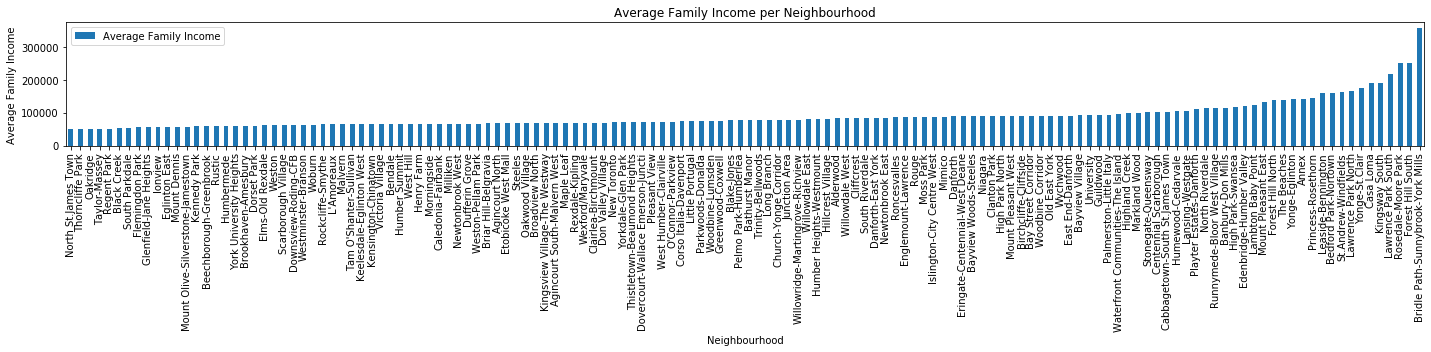

In [10]:
#To get a better breakdown I will look at the average family income for the neighbourhoods in a graph form
#After I will also look at the distribution of mediterranean population throughout the neighbourhoods
df_graph=df_demo[['Neighbourhood', 'Average Family Income']].set_index('Neighbourhood')
# to make the graph more asthetically pleasing I will sort by ascending
df_graph.sort_values(by='Average Family Income', ascending=True,inplace=True)

#Now for the bar graph
df_graph.plot(kind='bar', figsize=(20,5))
plt.title('Average Family Income per Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Average Family Income')
plt.tight_layout()

plt.show()


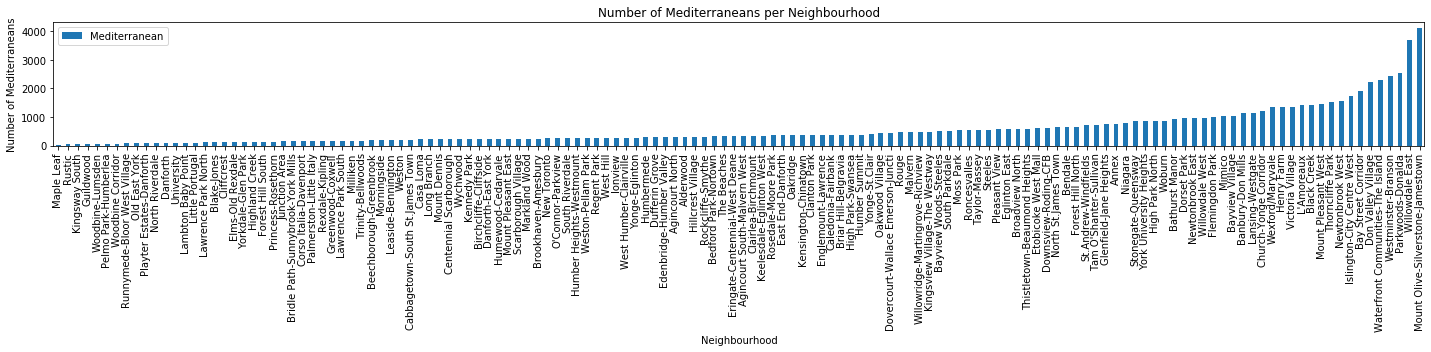

In [11]:
#Now looking at the distribution og Mediterraneans in each neighbourhood
df_graph2=df_demo[['Neighbourhood', 'Mediterranean']].set_index('Neighbourhood')
# to make the graph more asthetically pleasing I will sort by ascending
df_graph2.sort_values(by='Mediterranean', ascending=True,inplace=True)

#Now for the bar graph
df_graph2.plot(kind='bar', figsize=(20,5))
plt.title('Number of Mediterraneans per Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Number of Mediterraneans')
plt.tight_layout()

plt.show()

In [12]:
#The next step is to use four square api to fin the current mediterranean restaurants in Toronto
#Client id and client secret left blank since this is being published on a public git hub
CLIENT_ID = '' 
CLIENT_SECRET = '' 
VERSION = '20180605' # Foursquare API version
LIMIT = 50

In [13]:
#using a function I used in a previous project
def NearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
#Grabbing the nearby venues 
venues_tor=NearbyVenues(names=tor_df['Neighbourhood'],
                                 latitudes=tor_df['Latitude'],
                                 longitudes=tor_df['Longitude'])
venues_tor

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,SEBS Engineering Inc. (Sustainable Energy and ...,43.782371,-79.156820,Construction & Landscaping
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
...,...,...,...,...,...,...,...
1663,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,LCBO,43.741508,-79.584501,Liquor Store
1664,"Northwest, West Humber - Clairville",43.706748,-79.594054,Economy Rent A Car,43.708471,-79.589943,Rental Car Location
1665,"Northwest, West Humber - Clairville",43.706748,-79.594054,Logistics Distribution,43.707554,-79.589252,Bar
1666,"Northwest, West Humber - Clairville",43.706748,-79.594054,Saand Rexdale,43.705072,-79.598725,Drugstore


Analyzing with One Hot encoding

In [28]:
# one hot encoding
toronto_onehot = pd.get_dummies(venues_tor[['Venue Category']], prefix="", prefix_sep="")

# adding the  neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = venues_tor['Neighbourhood'] 

# move the neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

#grouping together Mediterranean restaurants
torgrouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
torgrouped = torgrouped[['Neighbourhood', 'Mediterranean Restaurant','Greek Restaurant','Italian Restaurant']]
torgrouped.set_index('Neighbourhood', inplace=True)
torgrouped

,Mediterranean Restaurant,Greek Restaurant,Italian Restaurant
Neighbourhood,,,
Agincourt,0.0,0.000000,0.000000
"Alderwood, Long Branch",0.0,0.000000,0.000000
"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.000000,0.000000
Bayview Village,0.0,0.000000,0.000000
"Bedford Park, Lawrence Manor East",0.0,0.045455,0.090909
...,...,...,...
"Willowdale, Willowdale West",0.0,0.000000,0.000000
Woburn,0.0,0.000000,0.000000
Woodbine Heights,0.0,0.000000,0.000000


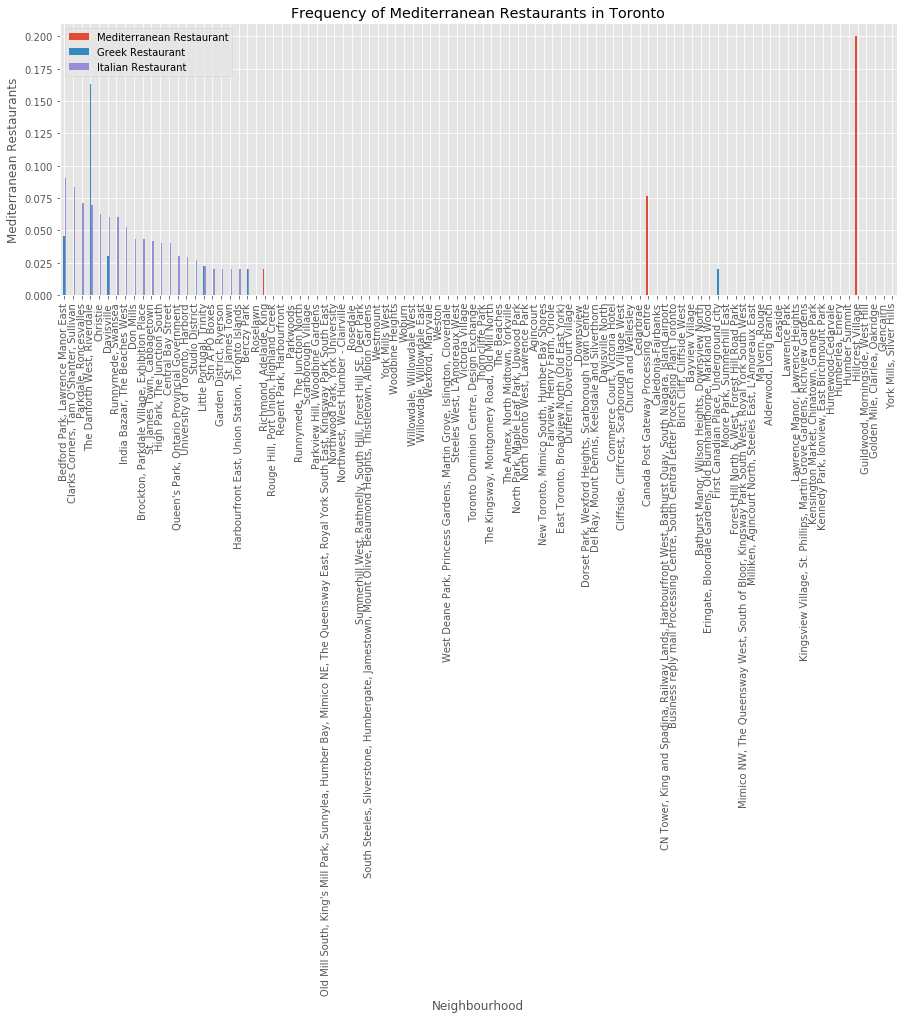

In [29]:
#Plotting  Where the Mediterranean restaurants are
# sort by descending order
torgrouped.sort_values(by='Mediterranean Restaurant'and 'Greek Restaurant'and 'Italian Restaurant', ascending=False, inplace=True)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')
torgrouped.plot(kind='bar', figsize=(15,5))

plt.title('Frequency of Mediterranean Restaurants in Toronto')
plt.xlabel('Neighbourhood')
plt.ylabel('Mediterranean Restaurants')

plt.show()

The next step is to merge the demographic dataframe with the geographic dataframe so we can then cluster

In [64]:
df_end = pd.merge(df_demo, torgrouped, on='Neighbourhood')
df_end.head()
df_new=df_end[['Neighbourhood',
 'Total Population',
 '   Arab',
 '   Europe',
 '   West Asia/Middle East','Mediterranean',
 'Average Family Income',
 'Mediterranean Restaurant',
 'Greek Restaurant',
 'Italian Restaurant']]
df_new

,Neighbourhood,Total Population,Arab,Europe,West Asia/Middle East,Mediterranean,Average Family Income,Mediterranean Restaurant,Greek Restaurant,Italian Restaurant
0,Humber Summit,12416,205,0,180,385,65757,0.0,0.0,0.0
1,Victoria Village,17510,1070,110,185,1365,65104,0.0,0.0,0.0
2,Hillcrest Village,16934,180,65,60,305,81484,0.2,0.0,0.0
3,Bayview Village,21396,355,230,450,1035,92800,0.0,0.0,0.0
4,Thorncliffe Park,21108,685,405,420,1510,49530,0.0,0.0,0.0
5,The Beaches,21567,90,230,0,320,139757,0.0,0.0,0.0
6,Humewood-Cedarvale,14365,115,95,25,235,105770,0.0,0.0,0.0
7,Weston,17992,120,80,0,200,61470,0.0,0.0,0.0
8,Woburn,53485,610,115,150,875,63186,0.0,0.0,0.0
9,Scarborough Village,16724,140,90,15,245,61631,0.0,0.0,0.0


Now to prep for clustering and then cluster the data

In [66]:
#Finding the appropriate number of clusters
#First step is to scale the continuous features since we need to give equal importance to all features
from sklearn.preprocessing import StandardScaler
X = df_end.values[:,6:]
X = np.nan_to_num(X)
Clusters = StandardScaler().fit_transform(X)
Clusters
df_normal=pd.DataFrame(Clusters)
df_normal

,0,1,2,3
0,-0.548962,-0.333333,0.0,0.0
1,1.500497,-0.333333,0.0,0.0
2,-0.716265,3.000000,0.0,0.0
3,0.810373,-0.333333,0.0,0.0
4,1.803733,-0.333333,0.0,0.0
5,-0.684896,-0.333333,0.0,0.0
6,-0.862655,-0.333333,0.0,0.0
7,-0.935850,-0.333333,0.0,0.0
8,0.475767,-0.333333,0.0,0.0
9,-0.841742,-0.333333,0.0,0.0


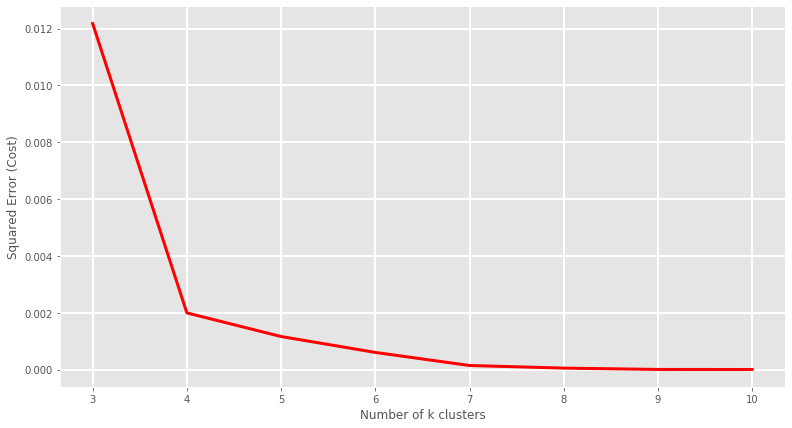

In [74]:
import random 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
%matplotlib inline


error_cost=[]

for i in range(3, 11):
  KM = KMeans(n_clusters=i, max_iter=100)
  try:
    KM.fit(df_normal)

  except ValueError:
    print('Error on line', i)

  # calculate squared error for the clustered points
  error_cost.append(KM.inertia_ / 100)

# plot the K values against the squared error cost
plt.figure(figsize=(13,7))
plt.plot(range(3,11), error_cost, color='r', linewidth=3)
plt.xlabel('Number of k clusters')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)

plt.show()

Using the previous plot the elbow is at k=4 therefore I will use 4 clusters for the analysis

In [76]:
#Doing k-means clustering
# set number of clusters
kclusters = 4

tor_clustering = df_end.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 0, 1, 2, 0, 1, 3, 1])

In [86]:
# add clustering labels
merged=pd.merge(tor_df,df_end, on='Neighbourhood')

#merged.insert(0, 'Cluster Label', kmeans.labels_) 
merged

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Label,Total Population,Arab,Europe,West Asia/Middle East,Average Family Income,Mediterranean,Mediterranean Restaurant,Greek Restaurant,Italian Restaurant
0,M1G,Scarborough,Woburn,43.770992,-79.216917,3,53485,610,115,150,63186,875,0.0,0.0,0.0
1,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1,16724,140,90,15,61631,245,0.0,0.0,0.0
2,M2H,North York,Hillcrest Village,43.803762,-79.363452,0,16934,180,65,60,81484,305,0.2,0.0,0.0
3,M2K,North York,Bayview Village,43.786947,-79.385975,0,21396,355,230,450,92800,1035,0.0,0.0,0.0
4,M4A,North York,Victoria Village,43.725882,-79.315572,1,17510,1070,110,185,65104,1365,0.0,0.0,0.0
5,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,21567,90,230,0,139757,320,0.0,0.0,0.0
6,M4H,East York,Thorncliffe Park,43.705369,-79.349372,1,21108,685,405,420,49530,1510,0.0,0.0,0.0
7,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,0,14365,115,95,25,105770,235,0.0,0.0,0.0
8,M9L,North York,Humber Summit,43.756303,-79.565963,1,12416,205,0,180,65757,385,0.0,0.0,0.0
9,M9N,York,Weston,43.706876,-79.518188,1,17992,120,80,0,61470,200,0.0,0.0,0.0


In [87]:
#visualizing the clusters
# create the map with the clusters overlayed on the top
map_clusters = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# adding the coloured markers for the neighbourhoods
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighbourhood'], merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now to examine  the clusters

In [88]:
merged.loc[merged['Cluster Label'] == 0]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Label,Total Population,Arab,Europe,West Asia/Middle East,Average Family Income,Mediterranean,Mediterranean Restaurant,Greek Restaurant,Italian Restaurant
2,M2H,North York,Hillcrest Village,43.803762,-79.363452,0,16934,180,65,60,81484,305,0.2,0.0,0.0
3,M2K,North York,Bayview Village,43.786947,-79.385975,0,21396,355,230,450,92800,1035,0.0,0.0,0.0
7,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,0,14365,115,95,25,105770,235,0.0,0.0,0.0


In [89]:
merged.loc[merged['Cluster Label'] == 1]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Label,Total Population,Arab,Europe,West Asia/Middle East,Average Family Income,Mediterranean,Mediterranean Restaurant,Greek Restaurant,Italian Restaurant
1,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1,16724,140,90,15,61631,245,0.0,0.0,0.0
4,M4A,North York,Victoria Village,43.725882,-79.315572,1,17510,1070,110,185,65104,1365,0.0,0.0,0.0
6,M4H,East York,Thorncliffe Park,43.705369,-79.349372,1,21108,685,405,420,49530,1510,0.0,0.0,0.0
8,M9L,North York,Humber Summit,43.756303,-79.565963,1,12416,205,0,180,65757,385,0.0,0.0,0.0
9,M9N,York,Weston,43.706876,-79.518188,1,17992,120,80,0,61470,200,0.0,0.0,0.0


In [90]:
merged.loc[merged['Cluster Label'] == 2]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Label,Total Population,Arab,Europe,West Asia/Middle East,Average Family Income,Mediterranean,Mediterranean Restaurant,Greek Restaurant,Italian Restaurant
5,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,21567,90,230,0,139757,320,0.0,0.0,0.0


In [91]:
merged.loc[merged['Cluster Label'] == 3]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Label,Total Population,Arab,Europe,West Asia/Middle East,Average Family Income,Mediterranean,Mediterranean Restaurant,Greek Restaurant,Italian Restaurant
0,M1G,Scarborough,Woburn,43.770992,-79.216917,3,53485,610,115,150,63186,875,0.0,0.0,0.0
